In [1]:
# notebook dedicated to computing various intrinsic metrics to see whether 
# they corresond to downstream performance and could be useful for RLHF

In [5]:
from transformers import AutoTokenizer
import pandas as pd
from rlhfutils.eval_utils import getapfsft, tok_dist
import matplotlib.pyplot as plt
from rlhfutils.debug_utils import load_rm, progress_rm, load_all_rmdfs, load_all_hackdfs
from statistics import mean, stdev
from scipy.stats import pearsonr, kendalltau, spearmanr
import math


In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
# replace all wgptouts with corresponding stack QA format (RM input format)
def setall(l):
    newl = []
    try:
        for ind in l:
            newl.append(getapfsft(ind, True))
            #print(0)
    except:
        return None
    return newl

def splitall(l):
    try: 
        return [s.split("Answer:")[1] for s in l]
    except:
        return None

def getfulldist(lcol):
    hist = []
    for l in lcol:
        hist.extend(l)
    return hist

def compdist(lcol, slen):
    res = []
    tmp = []
    for i in range(len(lcol)):
        tmp.append(lcol[i])
        if len(tmp)%slen==0:
            res.append(tmp)
            tmp = []
    return res
    
def procall(indf, toker, needset=True):
    if needset:
        indf['response'] = [setall(s) for s in indf['response']]
    indf = indf.dropna()
    indf['answers'] = [splitall(s) for s in indf['response']]
    indf = indf.dropna()
    indf['atoks'] = [tok_dist(s, wgtok) for s in list(indf['answers'])]
    indf['ttoks'] = [tok_dist(s, wgtok) for s in list(indf['response'])]
    return indf
    

In [8]:
hds = load_all_hackdfs("../rm-attacks/attackouts/")

In [10]:
hds.keys()

dict_keys(['wgptda', 'stackrandaug', 'stacksanity', 'stackda', 'wgptorig', 'stackmix'])

In [11]:
hds['wgptda']

,origseq,origsco,bestseqs,bestscos,maxsco,diff
0,Question: How do our bodies produce heat?\n\nW...,0.758789,[Question: How do our bodies produce heat?\n\n...,[1.130859375],1.130859,0.372070
1,Question: How do our bodies produce heat?\n\nW...,0.440186,[Question: How do our bodies produce heat?\n\n...,[0.9995117188],0.999512,0.559326
2,Question: How do our bodies produce heat?\n\nW...,0.151367,[],[],0.151367,0.000000
3,Question: How do our bodies produce heat?\n\nW...,0.326660,[Question: How do our bodies produce heat?\n\n...,"[0.3842773438, 0.62890625, 1.0419921875]",1.041992,0.715332
4,Question: How do our bodies produce heat?\n\nW...,0.760742,[],[],0.760742,0.000000
...,...,...,...,...,...,...
1594,Question: Why are the storage of the phone cap...,0.308838,[Question: Why are the storage of the phone ca...,"[0.4128417969, 0.5732421875, 0.5971679688, 0.7...",0.812500,0.503662
1595,Question: Why are the storage of the phone cap...,0.510742,[Question: Why are the storage of the phone ca...,[1.048828125],1.048828,0.538086
1596,Question: Why are the storage of the phone cap...,1.105469,[Question: Why are the storage of the phone ca...,[1.19140625],1.191406,0.085938
1597,Question: Why are the storage of the phone cap...,0.708496,[Question: Why are the storage of the phone ca...,"[0.7631835938, 0.8227539062, 0.822265625]",0.822754,0.114258


In [13]:
stacktok = AutoTokenizer.from_pretrained("../stack-llama/models/sft/")
wgtok = AutoTokenizer.from_pretrained("../webgpt-llama/models/sft10k/")

In [ ]:
tok, stackorigrm, kwargs = load_rm("../stack-llama/models/rewardbigdset/", 0)

In [40]:
wgptd = pd.read_json("../trl-general/genouts/generated_wgptmultisampset.jsonl", lines=True, orient='records')
stackd = pd.read_json("../trl-general/genouts/generated_stackmultisampset.jsonl", lines=True, orient='records')

In [42]:
wgptd = procall(wgptd, wgtok, True)
stackd = procall(stackd, stacktok, False)

/tmp/ipykernel_3119224/2436522125.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indf['answers'] = [splitall(s) for s in indf['response']]
Token indices sequence length is longer than the specified maximum sequence length for this model (630 > 512). Running this sequence through the model will result in indexing errors


In [43]:
wresps = pd.DataFrame({'response':getfulldist(wgptd['response'])})
stackresps = pd.DataFrame({'response':getfulldist(stackd['response'])})

In [16]:
rmdfs = load_all_rmdfs("../trl-general/rmtmps/")

In [17]:
rmdfs.keys()

dict_keys(['stack_shuffrewardda', 'stack_shuffrewardmixed', 'wgpt_shuffrewardmodel', 'wgpt_shuffrewardrandda', 'stack_shuffrewardsanity', 'stack_shuffrewardrandaug'])

In [90]:
keyval = "wgpt_rewardmodel"

In [82]:
def getcorr(row, pearson=False):
    if pearson:
        return pearsonr(row['atoks'], row['reward']).statistic
    else:
        return kendalltau(row['atoks'], row['reward']).statistic

In [85]:
for k in rmdfs.keys():
    print(k)
    keyval = k
    sps = [getcorr(r, True) for _, r in rmdfs[k].iterrows()]
    kts = [getcorr(r, False) for _, r in rmdfs[k].iterrows()]
    print(mean([s for s in sps if not math.isnan(s)]))
    print(mean([s for s in kts if not math.isnan(s)]))
    #print(spearmanr(getfulldist(rmdfs[keyval].reward), getfulldist(rmdfs[keyval].atoks)))
    #print(kendalltau(getfulldist(rmdfs[keyval].reward), getfulldist(rmdfs[keyval].atoks)))

stack_rewardmixed
0.26950082145072624
0.19858120402385648
wgpt_rewardmodel
0.7394691336720456
0.5822256148543397
wgpt_rewardrandda
0.48551730395099724
0.3612255397434974
stack_rewardda
0.4192680794305942
0.3137610095053727
stack_rewardsanity
0.3991052727728961
0.28856944489854125
stack_rewardrandaug
0.373110518642094
0.27109995120037533


(array([  94.,  482., 1565., 1944., 1199.,  667.,  252.,  103.,   47.,
          39.]),
 array([  2. ,  27.6,  53.2,  78.8, 104.4, 130. , 155.6, 181.2, 206.8,
        232.4, 258. ]),
 <BarContainer object of 10 artists>)

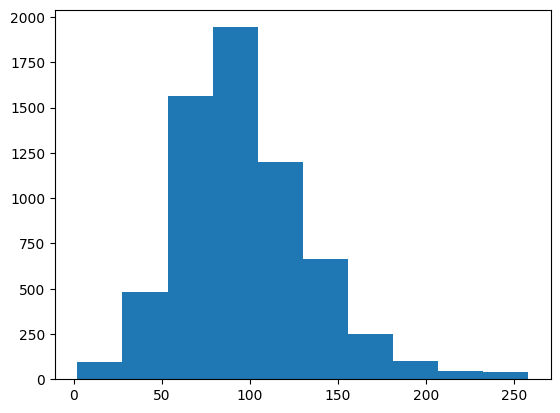

In [91]:
plt.hist(getfulldist(rmdfs[keyval].atoks))

In [19]:
for k in rmdfs.keys():
    print(k)
    keyval = k
    print(pearsonr(getfulldist(rmdfs[keyval].reward), getfulldist(rmdfs[keyval].atoks)))
    #print(spearmanr(getfulldist(rmdfs[keyval].reward), getfulldist(rmdfs[keyval].atoks)))
    # print(kendalltau(getfulldist(rmdfs[keyval].reward), getfulldist(rmdfs[keyval].atoks)))

stack_shuffrewardda
PearsonRResult(statistic=0.19360208722151298, pvalue=9.304967998824017e-55)
stack_shuffrewardmixed
PearsonRResult(statistic=-0.02117794872229203, pvalue=0.0912595806538025)
wgpt_shuffrewardmodel
PearsonRResult(statistic=0.6862010148602476, pvalue=0.0)
wgpt_shuffrewardrandda
PearsonRResult(statistic=0.24138648827280548, pvalue=2.0606832492580663e-85)
stack_shuffrewardsanity
PearsonRResult(statistic=0.09725125541677739, pvalue=7.685828382720676e-15)
stack_shuffrewardrandaug
PearsonRResult(statistic=0.07587236737730434, pvalue=1.3753695111232166e-09)


In [ ]:
print(mean([stdev(s) for s in rmdfs[keyval].reward])/stdev(getfulldist(rmdfs[keyval].reward)))
plt.hist([stdev(s) for s in rmdfs[keyval].reward])

In [ ]:
wgptorigrm = load_rm("../tr")

In [11]:
allresps = getfulldist(stackouts.response)

In [16]:
allscos = progress_rm(allresps[:100], stackorigrm, kwargs)

 57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 4/7 [00:32<00:27,  9.12s/it]/home/prasann/miniconda3/envs/rlenv/lib/python3.9/site-packages/transformers/pipelines/base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:49<00:00,  7.09s/it]


In [ ]:
compdist([a[0]['score'] for a in allscos], 8)

(array([ 229.,  526.,  818.,  767.,  656.,  560.,  466.,  340.,  289.,
        1709.]),
 array([  4. ,  30.2,  56.4,  82.6, 108.8, 135. , 161.2, 187.4, 213.6,
        239.8, 266. ]),
 <BarContainer object of 10 artists>)

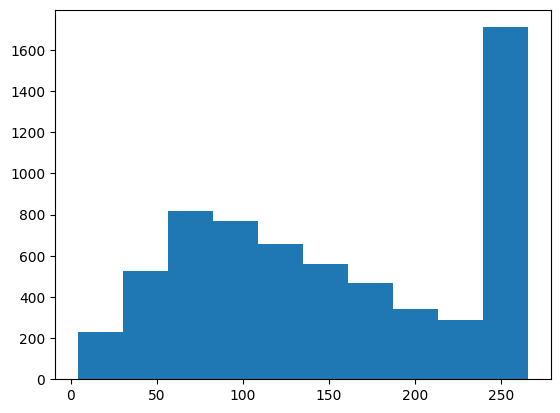

In [8]:
plt.hist(getfulldist(stackouts.atoks))